In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from models.mset import MSET
import warnings 
warnings.filterwarnings('ignore')

from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score

from utils.data import load_df, load_df_with_names, load_df_by_names
from utils.metrics import f1_score, far, mar

from typing import Dict



In [2]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']
# redundant_features = ['anomaly','changepoint','Accelerometer1RMS', 'Accelerometer2RMS', 'Current','Voltage','Pressure','Temperature', 'Thermocouple' ]
redundant_features = ['anomaly','changepoint','Accelerometer1RMS', 'Accelerometer2RMS', 'Current','Voltage','Thermocouple' ]

In [4]:
df_train = pd.read_csv("./data/valve1/6.csv", sep=";", parse_dates=True, index_col="datetime")
df_train.sort_index(inplace=True)

first_anomaly_idx = df_train.index.get_loc(df_train[df_train["anomaly"] == 1].index[0])
df_train = df_train.drop(redundant_features, axis=1)
train_size = int(first_anomaly_idx * 0.9)
train_size

518

In [5]:
x_train = df_train[:train_size]
x_train.head(3)

,Pressure,Temperature,Volume Flow RateRMS
datetime,,,
2020-03-09 12:14:36,0.382638,71.2129,32.0000
2020-03-09 12:14:37,0.710565,71.4284,32.0104
2020-03-09 12:14:38,0.054711,71.3468,32.0000


In [6]:
def movmean(array, window):

    n = np.size(array)
    xx = array.copy()
    y = []
    for i in range(0, window):
        y.append(np.roll(xx.tolist() + [np.nan]*window, i))
    y = np.nanmean(y, axis=0)
    l = math.ceil(window/2)

    return y[l-1:n+l-1]

In [7]:
from utils.pipeline import Pipeline, Predictor
from models.mset import MSET

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

import warnings 
warnings.filterwarnings('ignore')

In [8]:
from utils.pipeline import Pipeline, Predictor
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
class Config:
    train_size = 400
    window_size = 40
    Q = 0.6 # We know that 35% it is anomalies
    
conf = Config


class MsetPredictor:
    def fit(self, df_train):
        self.model = MSET()
        self.model.fit(df_train)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df.drop(redundant_features, axis=1)
            
            y_pred = self.model.predict(df)

            err = np.linalg.norm((y_pred.T - df), axis=1)
            rel_err = movmean(err/np.linalg.norm(y_pred.T, axis=1), window=Config.window_size)
            UCL = pd.Series(rel_err).quantile(Config.Q)

            prediction = pd.DataFrame((rel_err > UCL), df.index).fillna(0).any(axis=1).astype(int)
            predictions[file_name] = prediction
            
        return predictions
    

In [9]:
%%time
predictor = MsetPredictor()
predictor.fit(df_train)


CPU times: total: 15.6 ms
Wall time: 65 ms


In [10]:
# df_by_names = {"valve2/0.csv": pd.read_csv("data/valve2/0.csv", 
#                           sep=';', 
#                           index_col='datetime', 
#                           parse_dates=True)[:5]}
# df_by_names

In [11]:
%%time

df_by_names = load_df_by_names("./data/", ["valve1", "valve2"])
# df_by_names = load_df_by_names("./data/", ["valve2"])



y_test_by_names = {name: df.anomaly for name, df in df_by_names.items()}
predictions_by_names = predictor.predict(df_by_names)

CPU times: total: 21min 4s
Wall time: 21min 3s


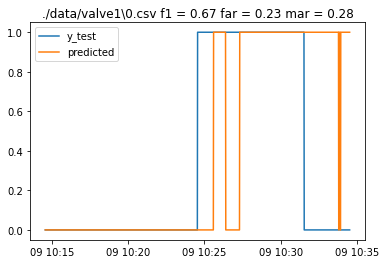

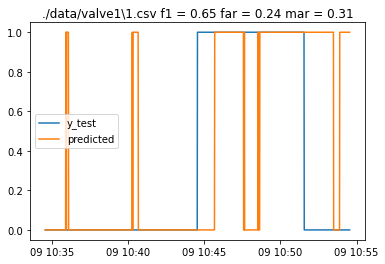

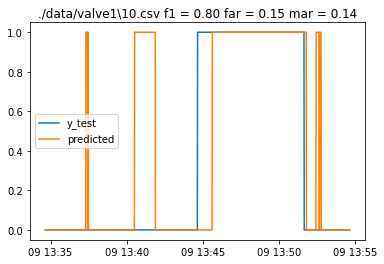

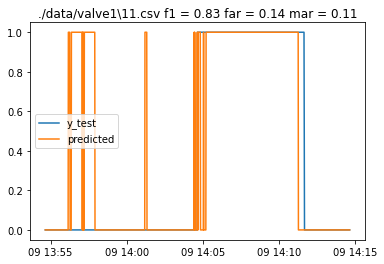

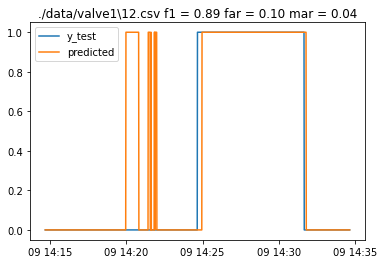

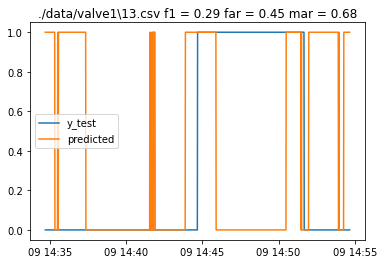

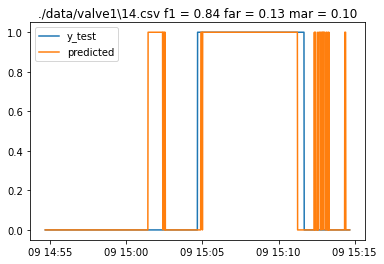

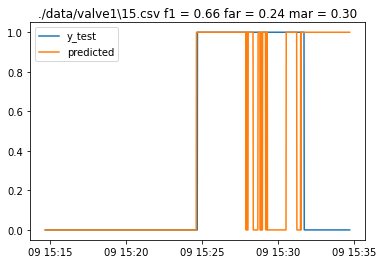

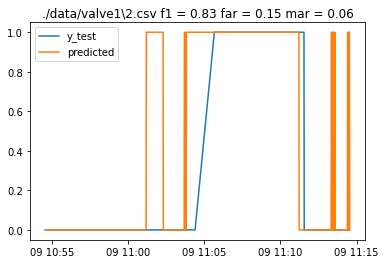

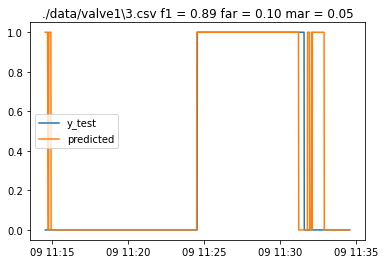

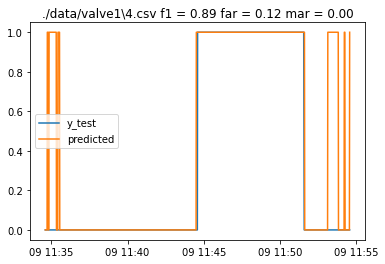

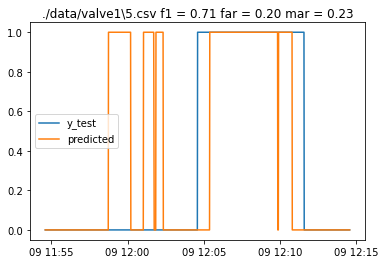

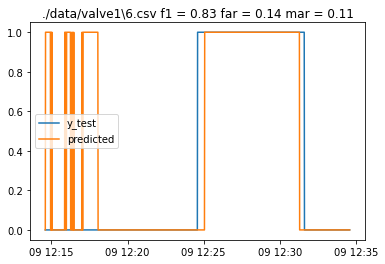

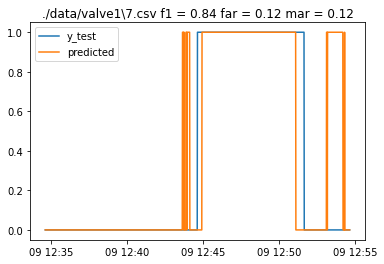

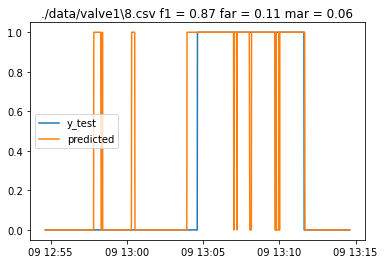

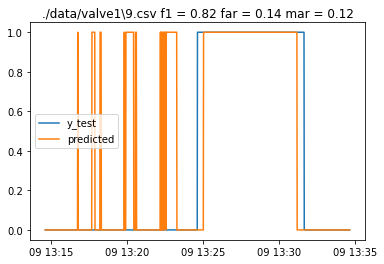

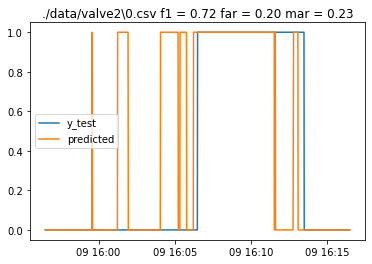

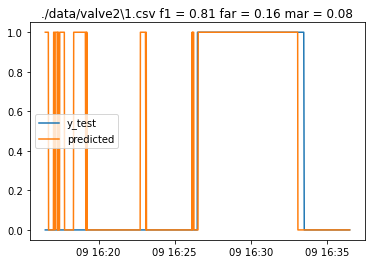

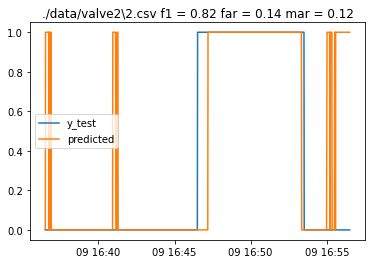

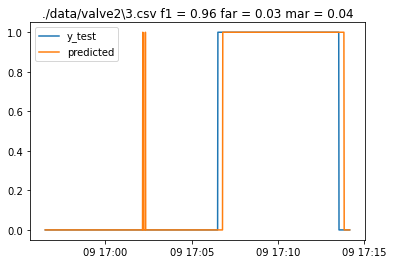

CPU times: total: 3.52 s
Wall time: 3.55 s


In [12]:
%%time
metrics= {}
predictions = []

draw = 1

all_prediction = {"valve1":[], "valve2":[]}
all_test = {"valve1":[], "valve2":[]}

for file_name, prediction in predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    # all_test.append(y_test)
    # all_prediction.append(prediction)
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    for i in [1,2]:
        if f"valve{i}" in file_name:
            all_prediction[f"valve{i}"].append(prediction)
            all_test[f"valve{i}"].append(y_test)
            
    metrics[file_name[7:]] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

        
grouped_metrics = {}
for group in (g for g in all_prediction if all_prediction[g]):    
    prc = pd.concat(all_prediction[group])
    tc = pd.concat(all_test[group])
    total_f1 = f1_score(tc, prc)
    total_far = far(tc, prc)
    total_mar = mar(tc, prc)
    grouped_metrics[group] = (total_f1, total_far, total_mar)

In [13]:
from utils.data import show_score_table

show_score_table(metrics)

show_score_table(grouped_metrics)

metric | valve1\0.csv | valve1\1.csv | valve1\10.csv | valve1\11.csv | valve1\12.csv | valve1\13.csv | valve1\14.csv | valve1\15.csv | valve1\2.csv | valve1\3.csv | valve1\4.csv | valve1\5.csv | valve1\6.csv | valve1\7.csv | valve1\8.csv | valve1\9.csv | valve2\0.csv | valve2\1.csv | valve2\2.csv | valve2\3.csv
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.67 | 0.65 | 0.8 | 0.83 | 0.89 | 0.29 | 0.84 | 0.66 | 0.83 | 0.89 | 0.89 | 0.71 | 0.83 | 0.84 | 0.87 | 0.82 | 0.72 | 0.81 | 0.82 | 0.96
FAR |0.23 | 0.24 | 0.15 | 0.14 | 0.1 | 0.45 | 0.13 | 0.24 | 0.15 | 0.1 | 0.12 | 0.2 | 0.14 | 0.12 | 0.11 | 0.14 | 0.2 | 0.16 | 0.14 | 0.03
MAR |0.28 | 0.31 | 0.14 | 0.11 | 0.04 | 0.68 | 0.1 | 0.3 | 0.06 | 0.05 | 0.0 | 0.23 | 0.11 | 0.12 | 0.06 | 0.12 | 0.23 | 0.08 | 0.12 | 0.04

metric | valve1 | valve2
--- | --- | ---
F1 |0.77 | 0.83
FAR |0.17 | 0.14
MAR |0.17 | 0.12

### SKAB MSET

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import linalg as spla
import os, sys
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

def kernel(x,y):

    '''
    s(x,y) = 1 - ||x-y||/(||x|| + ||y||)
    '''

    if all(x==y):
        # Handling the case of x and y both being the zero vector.
        return 1.
    else:
        return 1. - np.linalg.norm(x-y)/(np.linalg.norm(x) + np.linalg.norm(y))

def otimes(X, Y):

    m1,n = np.shape(X)
    m2,p = np.shape(Y)

    if m1!=m2:
        raise Exception('dimensionality mismatch between X and Y.')

    Z = np.zeros( (n,p) )

    if n != p:
        for i in range(n):
            for j in range(p):
                Z[i,j] = kernel(X[:,i], Y[:,j])
    else:
        for i in range(n):     
            for j in range(i, p):
                Z[i,j] = kernel(X[:,i], Y[:,j])
                Z[j,i] = Z[i,j]

    return Z

In [15]:
class SkabPredictor:        
    def __init__(self):
        pass
    
    def calc_W(self, X_obs):
        
        DxX_obs = otimes(self.D, X_obs)
        try:
            W = spla.lu_solve(self.LU_factors, DxX_obs)
        except:
            W = np.linalg.solve(self.DxD, DxX_obs)
    
        return W

    def fit(self, df):
        
        self.D = df.values.T.copy() # memory matrix
        self.SS = StandardScaler()
        self.D = self.SS.fit_transform(self.D.T).T
        
        self.DxD = otimes(self.D, self.D)
        self.LU_factors = spla.lu_factor(self.DxD)
        
    def predict(self, dfs_test: Dict[str, pd.DataFrame]) -> Dict[str, pd.Series]:
        predictions = {}
        for file_name, df in dfs_test.items():
            y_test = df.anomaly
            df = df.drop(redundant_features, axis=1)
            
            y_pred = self._predict_time_series(df)# 5 3
            err = np.linalg.norm((y_pred - df), axis=1)
            rel_err = movmean(err/np.linalg.norm(y_pred, axis=1), window=Config.window_size)
            UCL = pd.Series(rel_err).quantile(Config.Q)

            prediction = pd.DataFrame((rel_err > UCL), df.index).fillna(0).any(axis=1).astype(int)
            predictions[file_name] = prediction
            
        return predictions
        
    def _predict_time_series(self, df):
        X_obs = df.values.T.copy() 
        X_obs = self.SS.transform(X_obs.T).T
#         pred = pd.DataFrame(index=df.index, columns=df.columns)
        pred = np.zeros(X_obs.T.shape)
        
        for i in range(X_obs.shape[1]):
            pred[[i],:] = (self.D @ self.calc_W(X_obs[:,i].reshape([-1,1]))).T
            
        return pd.DataFrame(self.SS.inverse_transform(pred), index=df.index, columns=df.columns)

In [16]:
%%time
skab_predictor = SkabPredictor()
skab_predictor.fit(df_train)

CPU times: total: 24.9 s
Wall time: 24.9 s


In [17]:
%%time
skab_predictions_by_names = skab_predictor.predict(df_by_names)

CPU times: total: 16min 52s
Wall time: 17min 5s


In [18]:
skab_predictions_by_names

{'./data/valve1\\0.csv': datetime
 2020-03-09 10:14:33    1
 2020-03-09 10:14:34    1
 2020-03-09 10:14:35    1
 2020-03-09 10:14:36    1
 2020-03-09 10:14:37    1
                       ..
 2020-03-09 10:34:28    0
 2020-03-09 10:34:29    0
 2020-03-09 10:34:30    0
 2020-03-09 10:34:31    0
 2020-03-09 10:34:32    0
 Length: 1147, dtype: int32,
 './data/valve1\\1.csv': datetime
 2020-03-09 10:34:33    1
 2020-03-09 10:34:34    1
 2020-03-09 10:34:35    1
 2020-03-09 10:34:36    1
 2020-03-09 10:34:37    1
                       ..
 2020-03-09 10:54:29    0
 2020-03-09 10:54:30    0
 2020-03-09 10:54:31    0
 2020-03-09 10:54:32    0
 2020-03-09 10:54:33    0
 Length: 1145, dtype: int32,
 './data/valve1\\10.csv': datetime
 2020-03-09 13:34:39    1
 2020-03-09 13:34:40    1
 2020-03-09 13:34:41    1
 2020-03-09 13:34:43    1
 2020-03-09 13:34:44    1
                       ..
 2020-03-09 13:54:33    0
 2020-03-09 13:54:35    0
 2020-03-09 13:54:36    0
 2020-03-09 13:54:37    0
 2020-0

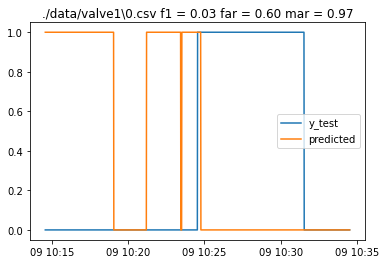

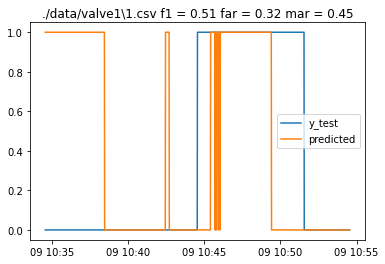

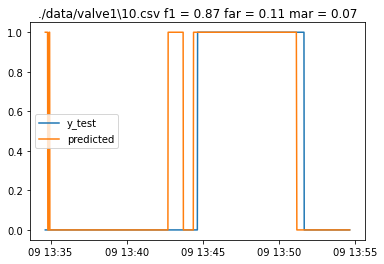

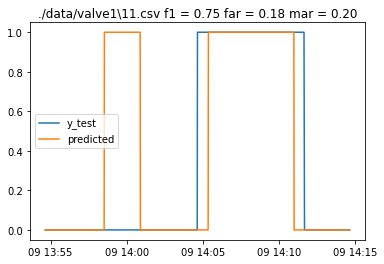

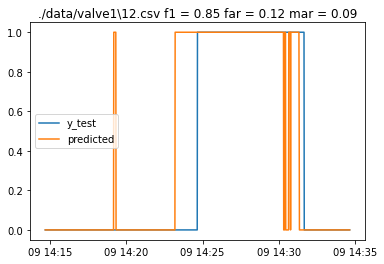

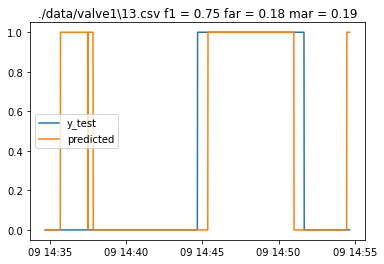

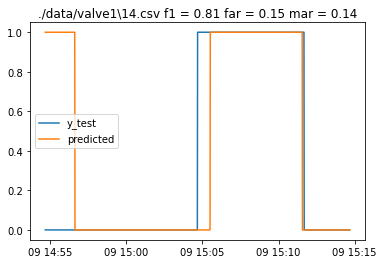

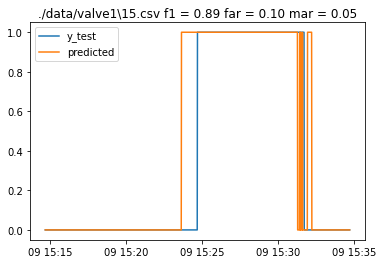

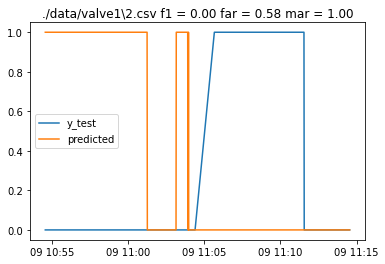

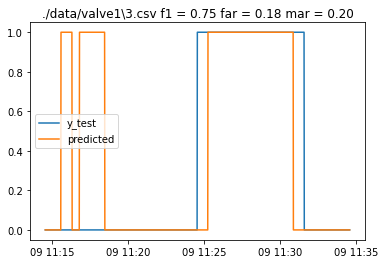

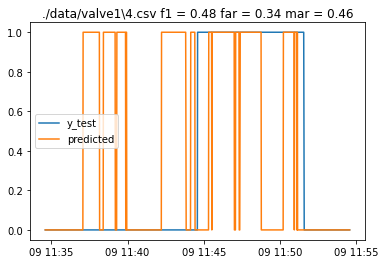

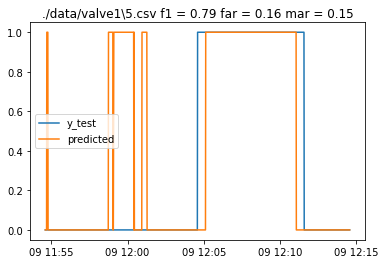

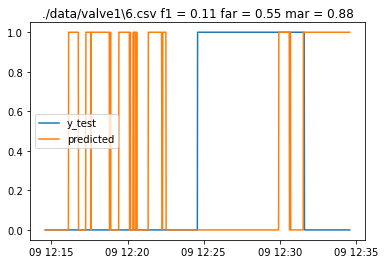

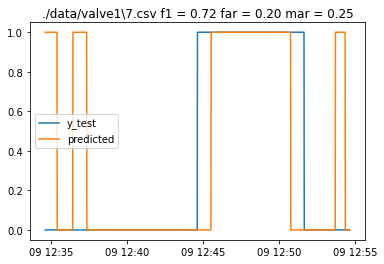

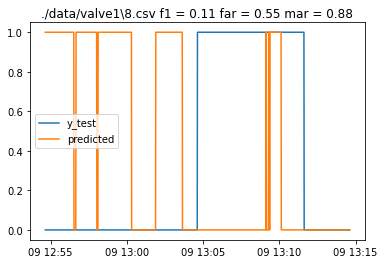

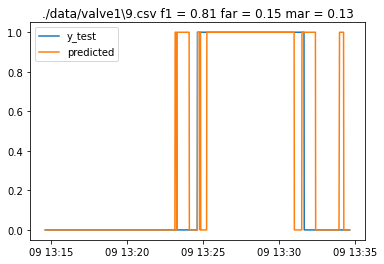

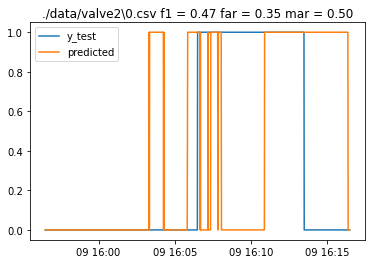

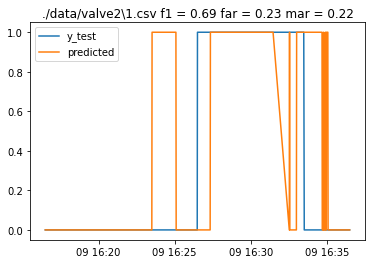

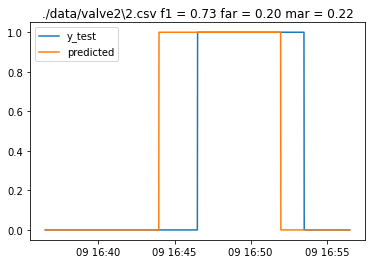

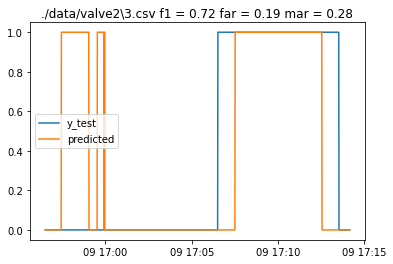

CPU times: total: 3.88 s
Wall time: 3.87 s


In [19]:
%%time
metrics= {}
predictions = []

draw = 1

all_prediction = {"valve1":[], "valve2":[]}
all_test = {"valve1":[], "valve2":[]}

for file_name, prediction in skab_predictions_by_names.items():
    y_test = y_test_by_names[file_name]
    # all_test.append(y_test)
    # all_prediction.append(prediction)
    f1 = f1_score(y_test, prediction)
    far_score = far(y_test, prediction)
    mar_score = mar(y_test, prediction)
    for i in [1,2]:
        if f"valve{i}" in file_name:
            all_prediction[f"valve{i}"].append(prediction)
            all_test[f"valve{i}"].append(y_test)
            
    metrics[file_name[7:]] = (f1, far_score, mar_score)
    
    if draw:
        title = file_name + " f1 = {:3.2f} far = {:3.2f} mar = {:3.2f}".format(f1, far_score, mar_score)
        plt.title(title)
        plt.plot(y_test)    
        plt.plot(prediction)
        plt.legend(["y_test", "predicted"])
        plt.show()

        
grouped_metrics = {}
for group in (g for g in all_prediction if all_prediction[g]):    
    prc = pd.concat(all_prediction[group])
    tc = pd.concat(all_test[group])
    total_f1 = f1_score(tc, prc)
    total_far = far(tc, prc)
    total_mar = mar(tc, prc)
    grouped_metrics[group] = (total_f1, total_far, total_mar)

In [20]:
from utils.data import show_score_table

show_score_table(metrics)

show_score_table(grouped_metrics)

metric | valve1\0.csv | valve1\1.csv | valve1\10.csv | valve1\11.csv | valve1\12.csv | valve1\13.csv | valve1\14.csv | valve1\15.csv | valve1\2.csv | valve1\3.csv | valve1\4.csv | valve1\5.csv | valve1\6.csv | valve1\7.csv | valve1\8.csv | valve1\9.csv | valve2\0.csv | valve2\1.csv | valve2\2.csv | valve2\3.csv
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.03 | 0.51 | 0.87 | 0.75 | 0.85 | 0.75 | 0.81 | 0.89 | 0.0 | 0.75 | 0.48 | 0.79 | 0.11 | 0.72 | 0.11 | 0.81 | 0.47 | 0.69 | 0.73 | 0.72
FAR |0.6 | 0.32 | 0.11 | 0.18 | 0.12 | 0.18 | 0.15 | 0.1 | 0.58 | 0.18 | 0.34 | 0.16 | 0.55 | 0.2 | 0.55 | 0.15 | 0.35 | 0.23 | 0.2 | 0.19
MAR |0.97 | 0.45 | 0.07 | 0.2 | 0.09 | 0.19 | 0.14 | 0.05 | 1.0 | 0.2 | 0.46 | 0.15 | 0.88 | 0.25 | 0.88 | 0.13 | 0.5 | 0.22 | 0.22 | 0.28

metric | valve1 | valve2
--- | --- | ---
F1 |0.58 | 0.65
FAR |0.28 | 0.24
MAR |0.38 | 0.31